In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('../datasets/imputed_data.csv',low_memory=False)
df.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df.isnull().sum()

TARGET                        0
NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
                             ..
AMT_REQ_CREDIT_BUREAU_DAY     0
AMT_REQ_CREDIT_BUREAU_WEEK    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
Length: 104, dtype: int64

In [4]:
df["TARGET"].value_counts(normalize=True)

TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

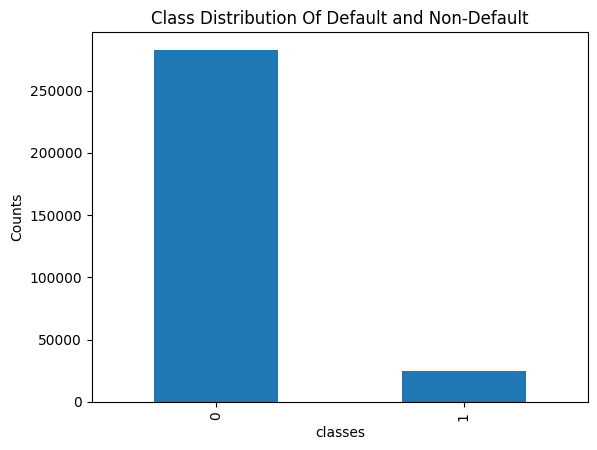

In [5]:
df["TARGET"].value_counts().plot(kind='bar')
plt.title("Class Distribution Of Default and Non-Default")
plt.xlabel("classes")
plt.ylabel("Counts")
plt.show()

In [6]:
#Imbelance Ratio
counts = df["TARGET"].value_counts()
ir = counts[0]/counts[1]
print(f"Imbalance Ratio: {ir:.2f} : 1") ## ratio

Imbalance Ratio: 11.39 : 1


In [7]:
X = df.drop("TARGET",axis=1)
y = df["TARGET"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [9]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
import category_encoders as ce
encoder = ce.WOEEncoder(cols=categorical_columns)
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)

In [10]:
from xgboost import XGBClassifier
scale_pos_weight = counts[0]/counts[1]
xgb_model = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    scale_pos_weight=5.35, 
    use_label_encoder=False,
    eval_metric='aucpr' # Focused on Precision-Recall for imbalanced data
)
xgb_model.fit(X_train_encoded,y_train)

C:\Users\Dell\OneDrive - City Community Education Consultancy Pvt. Ltd\Desktop\angorithem_and_error_analysis_for_imbelance\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [10:58:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [11]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
Xgb_model_prediction = xgb_model.predict(X_test_encoded)
print(classification_report(Xgb_model_prediction, y_test))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93     54665
           1       0.36      0.26      0.30      6838

    accuracy                           0.87     61503
   macro avg       0.64      0.60      0.61     61503
weighted avg       0.85      0.87      0.86     61503



In [12]:
y_probs = xgb_model.predict_proba(X_test_encoded)[:,1]
y_pred_new = (y_probs > 0.75).astype(int)

In [13]:
print("new report after changing the descission threshold")
print(classification_report(y_pred_new, y_test))

new report after changing the descission threshold
              precision    recall  f1-score   support

           0       0.99      0.92      0.96     60688
           1       0.08      0.46      0.13       815

    accuracy                           0.92     61503
   macro avg       0.53      0.69      0.54     61503
weighted avg       0.98      0.92      0.95     61503



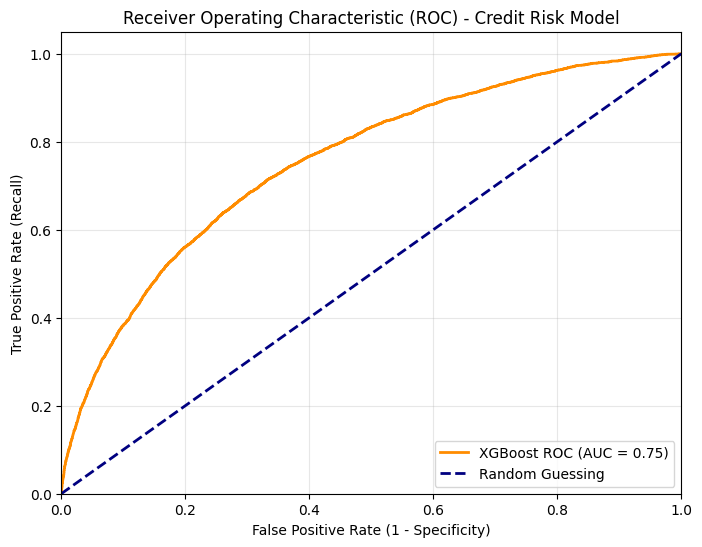

Total ROC-AUC Score: 0.7543


In [14]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'XGBoost ROC (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) - Credit Risk Model')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"Total ROC-AUC Score: {auc_score:.4f}")

In [15]:
from imblearn.ensemble import BalancedRandomForestClassifier

brf_model = BalancedRandomForestClassifier(
    n_estimators=500,
    sampling_strategy='auto', 
    replacement=False,
    bootstrap=True,
    random_state=42
)
brf_model.fit(X_train_encoded,y_train)

y_pred_brf = brf_model.predict(X_test_encoded)
print(classification_report(y_test, y_pred_brf))

              precision    recall  f1-score   support

           0       0.96      0.69      0.80     56554
           1       0.16      0.68      0.26      4949

    accuracy                           0.69     61503
   macro avg       0.56      0.69      0.53     61503
weighted avg       0.90      0.69      0.76     61503



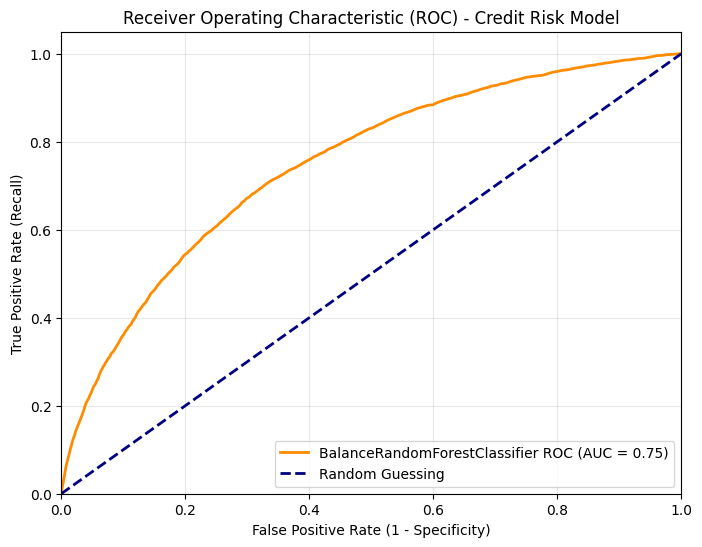

Total ROC-AUC Score: 0.7543


In [16]:
y_proba_bal = brf_model.predict_proba(X_test_encoded)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba_bal)
auc_score = roc_auc_score(y_test, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'BalanceRandomForestClassifier ROC (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) - Credit Risk Model')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"Total ROC-AUC Score: {auc_score:.4f}")

In [17]:
y_pred_bal_new = (y_proba_bal > 0.75).astype(int)
print(classification_report(y_pred_bal_new, y_test))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95     59641
           1       0.13      0.35      0.19      1862

    accuracy                           0.91     61503
   macro avg       0.56      0.64      0.57     61503
weighted avg       0.95      0.91      0.93     61503



In [18]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report


lgbm_model = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,         
    is_unbalance=True,      
    boosting_type='gbdt',
    importance_type='gain', 
    random_state=42
)


lgbm_model.fit(X_train_encoded, y_train)


y_pred_lgbm = lgbm_model.predict(X_test_encoded)
print(classification_report(y_test, y_pred_lgbm))


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8691
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 98
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
              precision    recall  f1-score   support

           0       0.96      0.75      0.84     56554
           1       0.18      0.61      0.28      4949

    accuracy                           0.74     61503
   macro avg       0.57      0.68      0.56     61503
weighted avg       0.89      0.74      0.80     61503



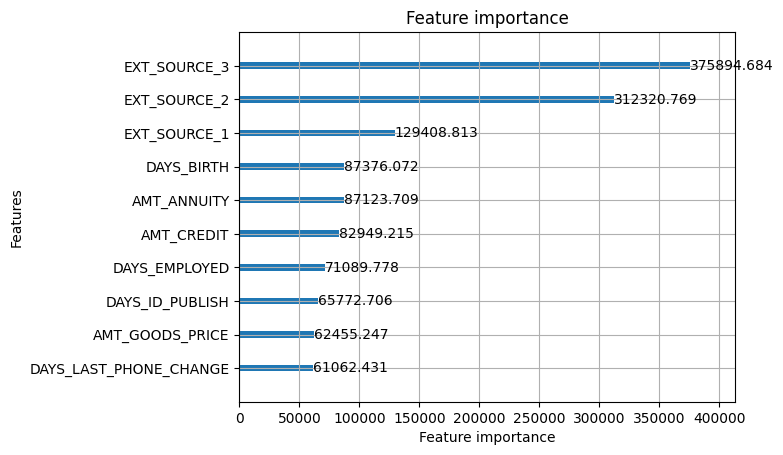

In [19]:
import lightgbm as lg
lg.plot_importance(lgbm_model, max_num_features=10, importance_type='gain')
plt.show()

In [26]:
import pandas as pd
from sklearn.metrics import classification_report

def get_report_df(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    df = pd.DataFrame({
        'Model': [model_name],
        'Recall (Default)': [report['1']['recall']],
        'Precision (Default)': [report['1']['precision']],
        'F1-Score (Default)': [report['1']['f1-score']],
        'Accuracy': [report['accuracy']]
    })
    return df


results_df = pd.concat([
    get_report_df(y_test, Xgb_model_prediction, "XGBoost"),
    get_report_df(y_test, y_pred_brf, "Balanced Random Forest"),
    get_report_df(y_test, y_pred_lgbm, "LightGBM")
]).reset_index(drop=True)


results_df.to_csv("model_comparison_results.csv", index=False)


In [ ]:
from catboost import CatBoostClassifier
cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    auto_class_weights='Balanced', 
    eval_metric='AUC',                  
    verbose=100
)
cat_model.fit(X_train_encoded, y_train)
y_pred_cat = cat_model.predict(X_test_encoded)
print(classification_report(y_pred_cat, y_test))

0:	total: 91.3ms	remaining: 1m 31s
100:	total: 6.83s	remaining: 1m
200:	total: 13.7s	remaining: 54.5s


In [ ]:
y_proba_cat = cat_model.predict_proba(X_test_encoded)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba_cat)
auc_score = roc_auc_score(y_test, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'CatBoostClassifier ROC (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) - Credit Risk Model')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"Total ROC-AUC Score: {auc_score:.4f}")

In [ ]:
y_pred_cat_new = (y_proba_cat > 0.75).astype(int)
print(classification_report(y_pred_cat_new, y_test))